# Inferring the Earth's tilt from day lengths

If you're more than 1 year old, you've probably notice that the **daylight length** (the time between sunrise and sunset) varies depending on the time of the year: it reaches its maximum and minimum at solstices, and is about 12 hours at equinoxes. What's more, as you approach the Equator, this variation gets smaller and smaller: at the Equator, you get about 12 hours of daylight per day, all year long.

This, as well as seasons, is explained by the **Earth's tilt**: the axis of rotation of the Earth is not quite parallel to its axis of rotation around the Sun. The angle between these axes is called the _Earth's tilt_ or *obliquity*; I'll denote it $\alpha$ in this article.

This has prompted me to tackle the following problem: 

### Problem statement

**_Can we, given the daylight lengths at various places and times around the globe, infer the Earth's tilt $\alpha$ reliably?_**

In [53]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import json
import io
import time
import numpy.random as rnd
import numpy.linalg as linalg
import datetime

## Collecting data

In [54]:
N = 200 ## the number of samples we want to collect


cities = [ ## some cities scattered over the world (between polar circles though)
  {'name': 'New York', 'pos': [40.7128, -74.0060]},
  {'name': 'Beijing', 'pos': [39.9042, 116.4074]},
  {'name': 'Buenos Aires', 'pos': [-34.6037, -58.3816]},
  {'name': 'Lisboa', 'pos': [38.7223, -9.1393]},
  {'name': 'Makassar', 'pos': [-5.1477, 119.4327]},
  {'name': 'Ushuaia', 'pos': [-54.8019, -68.3030]},
  {'name': 'Mumbai', 'pos': [19.0760, 72.8777]},
  {'name': 'Istanbul', 'pos': [41.0082, 28.9784]},
  {'name': 'Nairobi', 'pos': [-1.2921, 36.8219]},
  {'name': 'Sydney', 'pos': [-33.8688, 151.2093]},
  {'name': 'Los Angeles', 'pos': [34.0522, -118.2437]},
  {'name': 'Cape Town', 'pos': [-33.9249, 18.4241]},
  {'name': 'Noumea', 'pos': [-22.2735, 166.4481]},
  {'name': 'Tokyo', 'pos': [35.6762, 139.6503]}
  ]

epoch_2020 = datetime.datetime(2020,1,1).timestamp()
ordinal_2020 = datetime.date(2020,1,1).toordinal()
epoch_2019 = datetime.datetime(2019,1,1).timestamp()
ordinal_2019 = datetime.date(2019,1,1).toordinal()
year_duration_s = epoch_2020 - epoch_2019

def random_date_in_2019():
    return datetime.date.fromordinal(random.randrange(ordinal_2019, ordinal_2020))

def generate_data_template(N):
    ret = []
    for i in range(N):
        city = random.choice(cities)
        date = random_date_in_2019()
        m = {}
        m.update(city)
        m.update({'date': date.isoformat(), 'daylight': '?'})
        ret.append(m)
    def sortfn(m):
        return m['name'] + '|' + m['date']
    return sorted(ret, key=sortfn)

def print_data_template_as_json(template, out):
    out.write('[\n')
    for i in range(len(template)):
        if(i > 0):
            out.write(',\n')
        m = template[i]
        out.write(json.dumps(m))
    out.write('\n]\n')

def write_data_template_to_file():
    random.seed(38)
    template = generate_data_template(N)
    with open('./data/day-durations-template.json', 'w') as outfile:
        print_data_template_as_json(template, outfile)

We can now generate a data template to be filled manually by evaluating `write_data_template_to_file()`.

## Generic functions across all models

In [55]:
raw_training_data = json.load(io.open("./data/day-durations-training.json"))
raw_test_data = json.load(io.open("./data/day-durations-test.json"))

def parse_daylight_s(dl_raw):
    hours, minutes = dl_raw.split(':')
    return (3600 * float(hours)) + (60 * float(minutes))

def parse_year_fraction(date_raw, lng):
    ## TODO use lng
    y,m,d = date_raw.split('-')
    return (datetime.datetime(int(y),int(m),int(d)).timestamp() - epoch_2019) / year_duration_s

    
def daylight_durations(raw_data):
    arr = []
    for m in raw_data:
        arr.append(parse_daylight_s(m['daylight']))
    return np.array(arr)
        
daylight_durations(raw_training_data)

def rms_test_error(predicted_daylight_durations, actual_daylight_durations):
    return np.sqrt(np.average((predicted_daylight_durations - actual_daylight_durations)**2))

june21_yf = parse_year_fraction("2019-06-21", 0) ## The year fraction of the Summer Solstice
day_duration_s = 86400

## Model 1: a simple linear model

Our first model is the most elementary I could come up with, making several idealized hypotheses:

1. The Earth is a perfect sphere.
2. The Earth receives the light of the Sun as straight parallel rays (i.e the Sun is a punctual source at infinite distance).
3. The Earth orbits the Sun in a perfect circle at constant speed.
4. At a given latitude and time of the year, the daylight length is equal to the fraction of the iso-latitude circle that's in the light.

Based on these assumptions, I arrived at the following model:

---

#### Formula for Model 1:

$$ d_f = 1 - \frac{1}{\pi} \arccos(\sin(\alpha) \tan(\phi) \cos(2 \pi \frac{t - t_S}{T_Y})) $$

---

... in which the various symbols are defined as follows:

* $d_f$ : **daylight fraction**, the fraction of the day in daylight ($\frac{1}{2}$ if there are 12 hours of daylight, $\frac{2}{3}$ if there are 16 hours of daylight, etc.). _Part of the collected data._
* $\alpha$ : the **Earth's tilt**, an angle between 0° and 90°. _To be inferred._
* $\phi$ : the **latitude**, i.e the angle between the place in consideration and the Equator, ranging from -90° to 90°. _Part of the collected data._
* $t$ : the **time of the year**. _Part of the collected data._
* $t_S$ : the **time of Summer Solstice in the Northern Hemisphere**, the time of the year where days are longest in the Northern Hemisphere. _To be inferred._
* $T_Y$ : the **duration of the year.** _Known constant._

Let's restate **our goal: _infer the Earth's tilt $\alpha$ and the solstice time $t_S$ based on the collected values of $(d_f, \phi, t)$._**

### Framing Model 1 as a linear regression

A popular technique for fitting parameters to data is express the parameters as weights in a linear relationship between the data features, at which point Least-Squares-Fitting gives you a direct expression for the best-fit parameters.

Unfortunately, the above formula does not exhibit a linear relationship between $d_f$, $\phi$ and $t$, so we will need to rework it a little to get to a linear model.

First, our model can be rewritten to:

$$ \cos(\pi (1 - d_f)) = \sin(\alpha) \tan(\phi) \cos(2 \pi \frac{t - t_S}{T_Y}) $$

Here $\sin(\alpha)$ acts as a linear weight, so we've made progress. Unfortunately, the dependence on $t_S$ is still not linear. 

However, recalling the trigonometry identity $\cos(a-b) = \cos(a)\cos(b) + \sin(a)\sin(b)$, we can 'separate' $t$ and $t_S$ as follows:

$$\cos(2 \pi \frac{t - t_S}{T_Y}) =  \cos(2 \pi \frac{t_S}{T_Y})\cos(2 \pi \frac{t}{T_Y}) + \sin(2 \pi \frac{t_S}{T_Y})\sin(2 \pi \frac{t}{T_Y})$$

We can now rewrite our formula as:

$$ \cos(\pi (1 - d_f)) = \sin(\alpha) \cos(2 \pi \frac{t_S}{T_Y}) \tan(\phi) \cos(2 \pi \frac{t}{T_Y}) + \sin(\alpha) \sin(2 \pi \frac{t_S}{T_Y}) \tan(\phi) \sin(2 \pi \frac{t}{T_Y}) $$

It may not be immediately obvious, but the right-hand side is a linear combination between parameters and data features, which is what we need. 

To make it clearer, let's define $A := \sin(\alpha) \cos(2 \pi \frac{t_S}{T_Y})$ and $B:= \sin(\alpha) \sin(2 \pi \frac{t_S}{T_Y})$, our relationship then becomes:

---
#### Model 1 as a linear regression: 

$$ \cos(\pi (1 - d_f)) = A \tan(\phi) \cos(2 \pi \frac{t}{T_Y}) + B \tan(\phi) \sin(2 \pi \frac{t}{T_Y}) $$

... in which $d_f$, $t$ and $\phi$ are observed, and $A$, $B$ are model parameters.

---

We can now use 2-dimensional **linear least-squares regression** to find the best-fit values of $A$ and $B$, and then work out $\alpha$ and $t_S$ from these values.

### Model 1: implementing the regression

To run the linear regression, we will use a built-in function of `numpy.linalg`:

In [56]:
import numpy.linalg as linalg

First, we define a function that does the required _feature engineering_ to run linear regression, i.e compute the required basis functions and target values from the training data and put them into a matrix:

In [57]:
def model1_design_matrix(raw_data):
    """
    Processes the raw data into a matrix suitable for inferring model parameters via a linear regression.
    The first 2 columns are basis functions, the last one is the target.
    """
    rows = []
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = year_f * (2 * np.pi)
        tan_phi = np.tan(lat * np.pi / 180)
        night_fraction = (1 - dl_s / day_duration_s)
        target = np.cos(np.pi * night_fraction)
        rows.append([
          (tan_phi * np.cos(psi)),
          (tan_phi * np.sin(psi)),
          target
          ])
    return np.array(rows)

We then write a function that runs the linear regression, then returns the inferred values of $\alpha$ and $\frac{t_S}{T_Y}$:

In [58]:
def model1_fit_alpha_and_sf(raw_data):
    mat = model1_design_matrix(raw_data)
    N = len(raw_data)
    best_fit = linalg.lstsq(mat[:,0:-1], mat[:,-1], rcond=None)
    A,B = best_fit[0]
    alpha = np.arcsin((A**2 + B**2)**0.5)
    solstice_fraction = np.arccos(A / np.sin(alpha)) / (2 * np.pi)
    rmse = np.sqrt(best_fit[1][0] / N)
    return (alpha, solstice_fraction, rmse, best_fit)


### Model 1: results

Let's run this algorithm on our training data:

In [59]:
m1_alpha, m1_sf, _, m1_lsqfit = model1_fit_alpha_and_sf(raw_training_data)

... then print the **inferred parameters** in English:

In [60]:
def year_fraction_to_date(sf):
    return datetime.datetime.fromtimestamp(datetime.datetime(2019,1,1).timestamp() + sf * year_duration_s)

print('Inferred Earth tilt (alpha) and solstice date with linear regression: {:.2f}°, {}'.format(m1_alpha * 180 / np.pi, year_fraction_to_date(m1_sf).ctime())) ## 25.022396735018944°

Inferred Earth tilt (alpha) and solstice date with linear regression: 25.55°, Sat Jun 22 06:06:50 2019


That's not too bad! The actual values are something like 23.44° and June 21, so our model seems to be a reasonable approximation.

What's the **prediction error**?

In [61]:
def model1_daylight_predictions(raw_data, alpha, solstice_fraction):
    mat = model1_design_matrix(raw_data)
    sf2pi = 2 * np.pi * solstice_fraction
    p_cos_pi_nf = np.sin(alpha) * (np.cos(sf2pi ) * mat[:,0] + np.sin(sf2pi) * mat[:,1])
    return day_duration_s * (1 - np.arccos(p_cos_pi_nf) / np.pi)

print("On test data, Model 1 achieves a Root Mean Squared prediction error of {:.1f} minutes.".format(rms_test_error(model1_daylight_predictions(raw_test_data, m1_alpha, m1_sf), daylight_durations(raw_test_data))  / 60))

On test data, Model 1 achieves a Root Mean Squared prediction error of 11.1 minutes.


11 minutes of error, out of day lenghts on the order of 12 hours (720 minutes). It's not *that* bad.

To make things a bit more visual, let's plot the RMS error in the parameters landscape:

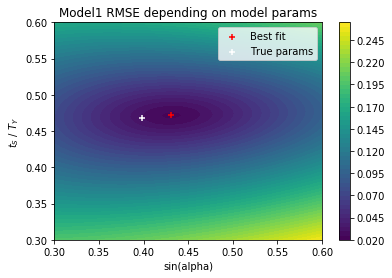

In [105]:
def plot_model1_rms(raw_data, fit_alpha, fit_soltice_yf):
    sin_alphas = np.linspace(0.3, 0.6, 5e2) ## sin alphas
    soltice_yearfs = np.linspace(0.3, 0.6, 5e2) ## solstice year_f

    C = np.zeros((np.shape(soltice_yearfs)[0], np.shape(sin_alphas)[0]))
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        tan_phi = np.tan(lat * np.pi / 180)
        night_fraction = (1 - dl_s / day_duration_s)
        target = np.cos(np.pi * night_fraction)
        Rn = (target -  tan_phi * np.matmul(np.transpose(np.mat(np.cos(2 * np.pi * (year_f - soltice_yearfs)))), np.mat(sin_alphas)))
        C += np.square(Rn)
    C = (C / N) ** 0.5

    fig, (ax0) = plt.subplots(nrows=1)
    im = ax0.contourf(sin_alphas, soltice_yearfs, C, 50)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('Model1 RMSE depending on model params')
    ax0.scatter(np.array([np.sin(fit_alpha)]), np.array([fit_soltice_yf]), marker='+', color='r', label="Best fit")
    ax0.scatter(np.array([np.sin(real_tilt)]), np.array([june21_yf]), marker='+', color='w', label="True params")
    ax0.yaxis.set_label_text('$t_S$ / $T_Y$')
    ax0.xaxis.set_label_text('sin(alpha)')
    ax0.legend()
    plt.show()

plot_model1_rms(raw_training_data, m1_alpha, m1_sf)  

## Model 1 bis - $\alpha$ as the only parameter

In this part, we treat the solstice time $t_S$ as a known constant, and infer only the Earth's tilt $\alpha$. 

This turns the problem into a 1-dimensional linear regression, which is easier to visualize.

In [63]:
psi_sf = 2 * np.pi * june21_yf

def fit_alpha_at_solstice(raw_data):
    mat = model1_design_matrix(raw_data)
    features = np.cos(psi_sf) * mat[:,0:1] + np.sin(psi_sf) * mat[:,1:2]
    best_fit = linalg.lstsq(features, mat[:,-1], rcond=None)
    sin_alpha = best_fit[0][0]
    alpha = np.arcsin(sin_alpha)
    rmse = np.sqrt(best_fit[1][0] / N)
    return (alpha, rmse, best_fit)

m1_alpha_2, _rmse, _ = fit_alpha_at_solstice(raw_training_data)

print('Inferred alpha with northern summer solstice at the correct date: {:.2f}'.format(m1_alpha_2 * 180 / np.pi)) ## 25.022396735018944°

Inferred alpha with northern summer solstice at the correct date: 25.51


Not much difference, as we see. But because we now only have one basis function, we can more easily plot visually the data and fitted curves:

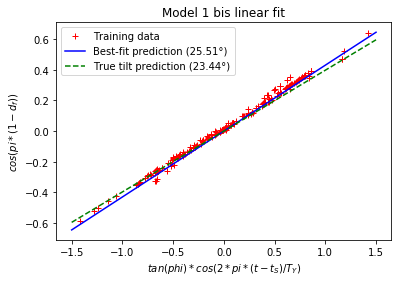

In [64]:
real_tilt = 23.44 * np.pi / 180

def plot_model1_bis_fit(raw_data, fit_alpha):
    mat = model1_design_matrix(raw_data)
    x_range = np.linspace(-1.5, 1.5, 100)
    plt.plot(
        np.cos(psi_sf) * mat[:,0] + np.sin(psi_sf) * mat[:,1],
        mat[:,2],
        'r+',
        label="Training data")
    plt.plot(
        x_range,
        np.sin(fit_alpha) * x_range,
        'b',
        label="Best-fit prediction ({:.2f}°)".format(fit_alpha * 180 / np.pi))
    plt.plot(
        x_range,
        np.sin(real_tilt) * x_range,
        'g--',
        label="True tilt prediction ({:.2f}°)".format(real_tilt * 180 / np.pi))
    ax = plt.gca()
    ax.set_title('Model 1 bis linear fit')
    ax.set_ylabel('$cos(pi * (1 - d_f))$')
    ax.set_xlabel('$tan(phi) * cos(2* pi * (t - t_S) / T_Y)$')
    plt.legend()
    plt.show()

plot_model1_bis_fit(raw_training_data, m1_alpha_2)

I find this visualization reassuring - our linear model, although idealized, is visually rather credible.

## Model 2: accounting for an excess angle $\epsilon$

### Refined physical model

<img src="./img/earth-tilt-sketch.jpg" />

Let's try refining our model. We'll start from the assumption that *some phenomenon* is causing our previous Model 1 to be slightly inaccurate - it could be the fact that the Sun is not punctual, or maybe atmospheric refraction... Whatever that *some phenomenon* is, we'll assume it respects a symmetry around the Earth-Sun axis.

This means that the sunlight covers a little more than half a sphere: **it 'overflows' by a small angle $\epsilon$.** Because the Earth orbit is close to circular, we'll assume that this angle is constant over time.

In addition to the Earth tilt $\alpha$, we'll now try to infer $\epsilon$ from the data.

The geometric derivation is a bit more involved here, but eventually I reached the following formula:

$$ \cos(\pi (1 - d_f)) = \sin(\epsilon) \frac{1}{\cos(\phi)\cos(\theta(t))} + \sin(\theta(t))\tan(\phi) $$

Here we introduce some **new notation:**

* $\theta(t)$ is the angle between the Earth Equatorial Plane and the Earth-Sun axis. This angle is 0 at equinoxes, and $\pm \alpha$ at solstices.
* We define a shorthand $\psi(t) := \frac{2 \pi (t - t_S)}{T_Y}$
* It can be shown that $\sin(\theta(t)) = \sin(\alpha)\cos(\psi(t))$

Recalling that $cos(a) = \pm \sqrt{1 - \sin(a)^2}$, the above formula expands into:

$$ \cos(\pi (1 - d_f)) = \frac{\sin(\epsilon)}{\cos(\phi)\sqrt{1 - \sin(\alpha)^2 \cos(\psi)^2}} + \sin(\alpha) \cos(\psi)\tan(\phi) $$

Compared to Model 1, we have added a new term involving $\epsilon$.

Remember, our goal is to infer $\alpha$ and $\epsilon$; we'll do that by inferring $u := \sin(\alpha)$ and $v := \sin(\epsilon)$. This yields the following **non-linear model in parameters $u$ and $v$:**

---
#### Formula for Model 2:

$$ \cos(\pi (1 - d_f)) = \frac{v}{\cos(\phi)\sqrt{1 - u^2 \cos(\psi)^2}} + u\cos(\psi)\tan(\phi) $$

... in which $d_f$, $\psi$, and $\phi$ are observed, and $u$, $v$ are model parameters.

---

This is not a linear model, so we won't be able to directly apply least-squares linear regression as we did for Model 1. But it doesn't mean that we can't apply least-squares regression at all: it only means that the resulting optimization problem is more difficult to solve.

### Implementing the regression by numerical optimization

We'll solve the optimization problem of least-squares fitting $u$ and $v$ to the data using a numerical algorithm.

In [65]:
import scipy.optimize as opt

Now, the $(u, v)$ parameter space that this algorithm has to explore is really quite small - a bounded box of 2 dimensions. So we could just use a 'brute-force' algorithm to find the best fit.

However I find it much more exiting to use an algorithm that makes use of differential information such as the gradient and hessian, and it gives me an occasion to show off some symbolic computing as well. What's more, having the Hessian will prove useful in the next section, when we use the Laplace Approximation for Bayesian inference.

Indeed, I could compute the gradient and Hessian by hand from the above formula, but I'm really terrible at this sort of calculation, so I'll let the machine do it for me:

In [66]:
import sympy as sy
from sympy.utilities.lambdify import lambdify

First, let's define some Sympy expressions for computing our error, in terms of our data and parameters:

In [67]:
t_n, phi_n, psi_n = sy.symbols('t_n phi_n psi_n') ## data
u, v = sy.symbols('u v') ## params

p_n = (v / ((sy.cos(phi_n) * sy.sqrt(1 - (sy.cos(psi_n) * u)**2)))) + (u * sy.tan(phi_n) * sy.cos(psi_n)) ## the prediction
g_n = t_n - p_n ## residual
e_n = (g_n ** 2) / 2 ## squared error

Here is our squared error term for one data point:

In [68]:
e_n

(t_n - u*cos(psi_n)*tan(phi_n) - v/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n)))**2/2

Here $t_n$ denotes the 'target' value of the regression, i.e $t_n := \cos(\pi (1 - d_f))$.

What amount of work can SymPy save us? As an example, let's compute one of the second derivatives that our algorithm will use:

In [69]:
sy.diff(e_n, u, v)

(u*v*cos(psi_n)/((-u**2*cos(psi_n)**2 + 1)**(3/2)*cos(phi_n)) + u*(-t_n + u*cos(psi_n)*tan(phi_n) + v/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n)))*cos(psi_n)/(-u**2*cos(psi_n)**2 + 1) + tan(phi_n))*cos(psi_n)/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n))

Ugh, alright, I'm happy not to have done it by hand.

Now let's implement our regression algorithm. As before, we start with a feature engineering function:

In [70]:
def model2_feature_matrix(raw_data):
    rows = []
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = (year_f - june21_yf) * (2 * np.pi)
        phi = lat * np.pi / 180
        night_fraction = (1 - dl_s / day_duration_s)
        t = np.cos(np.pi * night_fraction)
        rows.append([
          phi,
          psi,
          t
          ])
    return np.array(rows)

Now, we'll use `scipy.optimize` to minimize the sum of squared errors, while leaving the heavy lifting of evaluating the error and its derivatives to `sympy`. Because this is a small-dimensional problem and we have exact derivative information, we'll use the `trust-exact` method:

In [71]:
def model2_fit_params(raw_data):
    feat_mat = model2_feature_matrix(raw_data)

    t = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    lam_en = lambdify([t_n, phi_n, psi_n, u, v], e_n)
    def squared_error(u_v):
        u, v = u_v
        return np.average(lam_en(t, phi, psi, u, v))

    jac_lambdas = [lambdify([t_n, phi_n, psi_n, u, v], sy.diff(e_n, var1)) for var1 in [u, v]]
    def squared_err_jac(u_v):
        u, v = u_v
        return np.array([np.average(l(t, phi, psi, u, v)) for l in jac_lambdas])

    hess_lambdas = [[lambdify([t_n, phi_n, psi_n, u, v], sy.diff(e_n, var1, var2)) for var2 in [u, v]] for var1 in [u, v]]    
    def squared_err_hess(u_v):
        u, v = u_v
        return np.array([[np.average(l(t, phi, psi, u, v)) for l in row] for row in hess_lambdas])

    def squared_err_hessp(u_v, p):
        hess = np.matrix(squared_err_hess(u_v))
        return np.matmul(hess, p)

    opt_res = opt.minimize(
        squared_error, (0.01, 0.01), 
        bounds = ((0, 1), (0, 1)),
        method='trust-exact', 
        jac=squared_err_jac, 
        hess=squared_err_hess
        )
    
    return opt_res

### Model 2: results

Let's run the above algorithm on our training data, to see the **inferred parameters**:

In [72]:
model2_optres = model2_fit_params(raw_training_data)
u_opt, v_opt = model2_optres.x
print("Model 2 best-fit params are alpha = {:.2f}° and epsilon = {:.2f}°".format(np.arcsin(u_opt) * 180 / np.pi, np.arcsin(v_opt) * 180 / np.pi))
model2_rmse = np.sqrt(model2_optres.fun * 2)

Model 2 best-fit params are alpha = 25.38° and epsilon = 0.84°


Bad news: we don't get a much better fit for $\alpha$. But we do get a non-zero value for $\epsilon$, so it might still be that our refined model is an improvement. What **test error** do we get now?

In [73]:
def model2_daylight_predictions(raw_data, u_opt, v_opt):
    feat_mat = model2_feature_matrix(raw_data)
    lam_pn = lambdify([phi_n, psi_n, u, v], p_n)
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    p_cos_pi_nf = lam_pn(phi, psi, u_opt, v_opt)
    return day_duration_s * (1 - np.arccos(p_cos_pi_nf) / np.pi)

print("On test data, Model 2 achieves a Root Mean Squared prediction error of {:.1f} minutes.".format(rms_test_error(model2_daylight_predictions(raw_test_data, u_opt, v_opt), daylight_durations(raw_test_data))  / 60))


On test data, Model 2 achieves a Root Mean Squared prediction error of 3.9 minutes.


Cool, we got our error down from 11 minutes to about 4 minutes!

Are we sure we found the best-fit values for our parameters? As before, let's plot our optimization landscape:

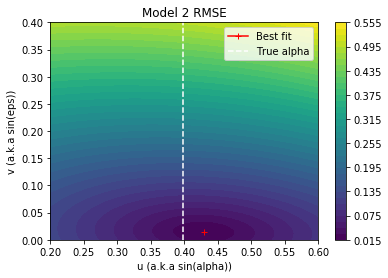

In [74]:
def plot_model2_rms(raw_data, model2_optres):
    u_opt, v_opt = model2_optres.x
    
    us = np.linspace(0.2, 0.6, 1e2)
    vs = np.linspace(0.0, 0.4, 1e2)

    C2 = np.zeros((np.shape(vs)[0], np.shape(us)[0]))
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = 2 * np.pi * (year_f - june21_yf)
        phi = lat * np.pi / 180
        night_fraction = (1 - dl_s / day_duration_s)
        t = np.cos(np.pi * night_fraction)
        Rn = np.square(t - np.matmul(np.mat(vs).transpose(), np.mat((1 - (np.cos(psi) * us) ** 2) ** (-0.5) / np.cos(phi))) - np.tan(phi) * np.cos(psi) * np.matmul(np.mat(np.ones(len(vs))).transpose(), np.mat(us)))
        C2 += Rn
    C2 = (C2 / N) ** 0.5

    fig, (ax0) = plt.subplots(nrows=1)
    im = ax0.contourf(us, vs, C2, 50)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('Model 2 RMSE')
    ax0.xaxis.set_label_text('u (a.k.a sin(alpha))')
    ax0.yaxis.set_label_text('v (a.k.a sin(eps))')
    ax0.plot([u_opt], [v_opt], marker='+', color='r', label="Best fit")
    ax0.plot(np.full(len(vs), np.sin(real_tilt)), vs, color='w', linestyle='--', label="True alpha")
    ax0.legend()
    plt.show()
    
plot_model2_rms(raw_training_data, model2_optres)

This looks like a nicely convex problem, well approximated by a quadratic function, so its no surprise that a Hessian-based algorithm quickly converged to the best solution:

In [75]:
model2_optres

     fun: 0.0001239977572583541
    hess: array([[0.29566738, 0.04806548],
       [0.04806548, 1.70032203]])
     jac: array([3.64946893e-07, 1.66596319e-07])
 message: 'Optimization terminated successfully.'
    nfev: 3
    nhev: 3
     nit: 2
    njev: 3
  status: 0
 success: True
       x: array([0.42866841, 0.01458687])

The above object is a `scipy.optimize` optimization result. We see that the optimization converged in only 2 iterations. Also notice that we get the best-fit point (`x`), value (`fun`) and hessian (`hess`) - these will be useful in the next section!

## Bayesian analysis

The above analysis leaves some questions open. Model 2 fits the data better, but Model 1 is simpler, so it's not clear which one we should prefer. What's more, we have found best-fit parameters for both models, but we don't know what kind of _confidence_ the models have around these inferred values - in particular, could the difference between 23.44° and 25.5° be explained by the fact that inference made by the model is a 'fuzzy' one?

I'll approach these questions using Bayesian methods. This means that I will use a probability distribution to quantify my (our) 'belief' regarding what values our model parameters might take, and then use the observed data to update this belief based on new information, which will result in focusing this probability distribution.

Professional data scientists would typically use specific software package for this, but for our small-scale problem Scipy will suffice, and I find it interesting to see how Scipy might be used for Bayesian analysis.

### A review of Bayesian methods

Say we have a model $M_i$ for our data. This model has parameters $\Theta$, and our goal is to infer $\Theta$ from observed data $D$.

We start by choosing a _prior distribution_ $P(\Theta | M_i)$ that we can all agree on for our parameters: this is a probability distribution which describes quantitatively what values $\Theta$ might reasonably take. $P(\Theta | M_i)$ will typically be rather broad, because we want to be open-minded about the possible values of our parameters.

We also choose a probability distribution $P(D | \Theta, M_i)$ for the observed data $D$ given the parameters $\Theta$. In the case of curve-fitting (which is what we're doing here), the observed data $D$ will typically consist of observations $(t_n, x_n)$, describe probabilistically as $t_n = f_{\Theta}(x_n) + \nu_n$, where the $\nu_n$ are independent 'noise' random variables which distribution depends on $\Theta$ (a common choice is to choose 0-mean gaussian distributions for the $\nu_n$).

Having done that, we infer our _posterior belief_ in the parameters using Bayes' Theorem:

$$P(\Theta | D, M_i) = \frac{1}{P(D | M_i)} P(D | \Theta, M_i) P(\Theta | M_i)$$

In the above formula, the only factor we can't compute directly is $P(D | M_i)$, a.k.a the _model evidence_. But note that it does not depend on $\Theta$, so that $\frac{1}{P(D | M_i)}$ can be treated as a normalization constant. What's more, since $P(\Theta | D, M_i)$ is a probability density for $\Theta$ (thus summing to $1$):

$$ P(D | M_i) = \int{P(D | \Theta, M_i) P(\Theta | M_i) d\Theta} $$

### Bayesian analysis of Model 1

In the case of Model 1, we define $\Theta := (u, \sigma)$ where $u = \sin(\alpha)$ and $\sigma$ is the standard deviation for the noise around observations.

We choose $P(D | \Theta, M_1)$ by saying that:

$$t_n = f_{\Theta}(\phi_n, \psi_n) + \nu_n$$ 

...where:

* $t_n := \cos(\pi (1 - d_f))$ is the 'target' variable of the regression.
* $\phi_n$ is the latitude, $\psi_n$ is the angle representing the time of the year ($\psi := 2 \pi \frac{t - t_S}{T_Y}$)
* $f_{\Theta}(\phi_n, \psi_n) := u \tan(\phi_n) \cos(\psi_n)$
* $\nu_n$ is the element of randomness: a 'noise' random variable with a 0-mean gaussian distribution, i.e:

$$P(\nu_n | \Theta, M_1) = \frac{1}{\sqrt{2 \pi} \sigma} e^{-\frac{\nu_n^2}{2 \sigma^2}}$$

The above may seem arbitrary, but we have only reformulated our previous least-squares regression problem in probabilistic terms, so we are not really departing from Model 1. (More precisely, what we did in the least-squares regression corresponded to finding a _maximum likelihood_ estimate for $u$ in the above formula; our Bayesian analysis will yield a more nuanced answer as to what $u$ might be, as it will be a posterior probability distribution rather than a single point estimate).

Finally, we have to choose a prior $P(\Theta| M_1)$. I'll make the following assumptions, hopefully you won't find them too arbitrary:

1. Given that $u = sin(\alpha)$, I'll assume that **$u$ has a uniform distribution in $[0, 1]$.**
2. I have no precise idea of what the order of magnitude of $\sigma$ might be. Since $t_n$ ranges in $[0,1]$, I'll assume $\sigma$ can be no higher than $1$. Since my daylight lengths are measured with the precision of 1 minute, I expect at least that level of noise on $d_f$. To be open-minded about this, I'll assume $\sigma$ can't go below $10^{-4}$. Putting all these arguments together, I'll assume that **$\log_{10}(\sigma)$ has a uniform distribution in $[-4, 0]$.**

#### SymPy representation

To help with our future computations, let's program these modeled probabilities using SymPy. Because probabilities tend to multiply, and additions are easier to handle than multiplications, we'll work with log-probabilities rather than direct probabilities.

Let's start by describing our prior distribution by defining $\ln(P(\Theta =(u, \sigma) | M_1))$:

In [84]:
sigma = sy.symbols('sigma')

u_bounds = (0, 1)
sigma_bounds = (1e-4, 1)

lp1_theta = np.log(1 / (u_bounds[1] - u_bounds[0])) + sy.ln(1 / sigma) - np.log(np.log(sigma_bounds[1]) - np.log(sigma_bounds[0]))

lp1_theta

log(1/sigma) - 2.22032680636785

Now we define the probability $\ln(P(t_n, x_{1n}| \Theta, M_1))$ of observing a data point (here $x_{1n}$ is a shorhand for $\tan(\phi_n) \cos(\psi_n)$):

In [86]:
x_1 = sy.symbols('x_1n')
lp1_n = - sy.ln(sigma) - 0.5 * np.log(2 * np.pi) - (((t_n  - u * x_1) / sigma)**2) / 2
lp1_n

-log(sigma) - 0.918938533204673 - (t_n - u*x_1n)**2/(2*sigma**2)

Now let's start the work of inference.

#### Inference with the Laplace Approximation

As we saw above, exact computation of $P(\Theta | D, M_1)$ involves integrating the function $P_1^{*}(\Theta) := P(D | \Theta, M_i) P(\Theta | M_i)$. We can easily evaluate $P_1^{*}(\Theta)$ at a given point $\Theta$, but **integrals are not easy,** even for computers.

So instead of doing that, we'll first use an approximation called the **Laplace Method**. This approximation will turn out to be very accurate here, and will also help us do the exact integration downstream.

The Laplace Method consist at approximating $P(\Theta | D, M_1)$ by a Gaussian. To do that, we need to find a point $\Theta_{MAP}$ at which $P_1^{*}$ reaches its maximum ('MAP' stands for _Maximum A Posteriori_ ), as well as the Hessian of $P_1^{*}(\Theta)$ at $\Theta_{MAP}$, which will correspond to the precision matrix of the Gaussian.

Luckily, `scipy.optimize` gives us everything we need for doing that efficiently: we can use `scipy.optimize.minimize()` for finding $\Theta_{MAP}$ by minimizing $- \ln (P_1^{*}(\Theta))$, along with Sympy for differentiating (and in particular computing the Hessian).

I wrote a generic helper function [`find_map()`](./utils/scipy_bayes.py#L17) for doing that in a package `utils.scipy_bayes`, which we can now apply to Model 1:

In [76]:
import utils.scipy_bayes as scp_bayes

In [89]:
def find_model1_map(raw_data):
    mat = model1_design_matrix(raw_data)
    t = mat[:,-1]
    x_1s = np.cos(psi_sf) * mat[:,0] + np.sin(psi_sf) * mat[:,1]
    
    return scp_bayes.find_map(lp1_theta, lp1_n, [t_n, x_1], [u, sigma], [t, x_1s], [0.0, 0.1], (u_bounds, sigma_bounds))

m1_map = find_model1_map(raw_training_data)

In [78]:
m1_map

     fun: -458.13513570720363
    hess: array([[ 9.75260441e+04, -7.68195605e-08],
       [-7.68195605e-08,  6.63866833e+05]])
     jac: array([ 9.45078682e-10, -1.52221489e-08])
 message: 'Optimization terminated successfully.'
    nfev: 15
    nhev: 15
     nit: 14
    njev: 11
  status: 0
 success: True
       x: array([0.43069156, 0.02460779])

The above optimization result gives us the mean (`m1_map.x`) and precision matrix (`m1_map.hess`) of the approximating Gaussian. We can use these to compute 99% confidence intervals for $\alpha$ and $\sigma$. Again, we use a small generic function written for that purpose:

In [88]:
m1_alpha_99 = [np.arcsin(u) * 180 / np.pi for u in scp_bayes.laplace_99_confidence_interval(m1_map, 0)]
m1_alpha_99

[24.9031170507984, 26.122894405103352]

The true value of $\alpha$ (23.44°) falls well outside of this confidence interval, so I would not explain the inaccuracy of our estimate by the fussyness of our inference. Our model is _extremely confident_ that $\alpha \neq 23.44°$.

#### Inference with numerical integration

We'll now compute the posterior distribution using numerical integration.

`scipy.integrate` gives us ready-made algorithms for integration, but they unfortunately have trouble dealing with sharply-peaked integrands, as is typically the case of $P_1^{*}(\Theta)$. We'll need to help `scipy.integrate` a bit, by pointing it at a region where most of the probability mass lies.

Fortunately, our previous work for the Laplace Approximation as already given us all we need: $\Theta_{MAP}$ tells us where the probability peak is, and the Hessian tells us the approximate dimensions occupied by this peak.

Let's write a generic function for running the required integrations and plotting the posterior distribution of a model parameter:

In [106]:
import scipy.integrate as intgr

def plot_posterior(prior_logp_expr, datum_logp_expr, data_syms, theta_syms, data_values, theta0, theta_bounds, plotted_i):
    map_optres = scp_bayes.find_map(prior_logp_expr, datum_logp_expr, data_syms, theta_syms, data_values, theta0, theta_bounds)
    
    cov = linalg.inv(map_optres.hess)
    std_dev = np.sqrt(cov[plotted_i,plotted_i])
    mode = map_optres.x[plotted_i]
    radius = 5 * std_dev
    xs = np.linspace(mode - radius, mode + radius, 100)
    ## Laplace Approximation
    ys_lpl = np.array([np.exp(-0.5 * ((x - mode) / std_dev) ** 2) for x in xs])
    ys_lpl = ys_lpl / np.sum(ys_lpl)
    plt.plot(
            xs,
            ys_lpl,
            '',
            label="Laplace Approximation")
    
    all_syms = [] + list(data_syms) + list(theta_syms)
    lam_f_n = lambdify(all_syms, datum_logp_expr)
    lam_f_prior = lambdify(all_syms, prior_logp_expr)
    pvalues = [] + list(data_values)
    
    def f(theta):
        args = pvalues + list(theta)
        ## NOTE we're normalizing such that the density is 1 at the mode of the distribution.
        return np.exp(np.sum(lam_f_n(*args)) + lam_f_prior(*args) + map_optres.fun)

    D = len(theta_bounds)
    
    def fx(x):
        def h(*theta1):
            theta = theta1[0:plotted_i] + (x,) + theta1[plotted_i: D - 1]
            return f(theta)
        return h
    
    theta1_bounds = theta_bounds[0:plotted_i] + theta_bounds[plotted_i + 1: D]
    
    def var_intgr_opts(i):
        points = [(map_optres.x[i] + k*np.sqrt(cov[i,i])) for k in [-10, 0, 10]]
        return {'points': points}
    
    intgr_opts = [var_intgr_opts(i) for i in range(D) if i != plotted_i]
    
    def g(x):
        r, err = intgr.nquad(fx(x), theta1_bounds, opts=intgr_opts)
        return r
    
    ys_intr = np.array([g(x) for x in xs])
    ys_intr = ys_intr / np.sum(ys_intr)
    plt.plot(
            xs,
            ys_intr,
            '',
            label="Numerical Integration")
    ax = plt.gca()
    ax.set_title('Posterior probability of {}'.format(str(theta_syms[plotted_i])))
    ax.set_ylabel('Probability density')
    ax.set_xlabel(str(theta_syms[plotted_i]))
    plt.legend()
    plt.show()

Applying this to Model 1:

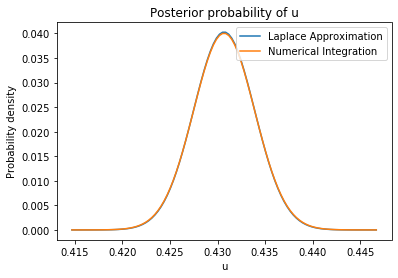

In [92]:
def plot_posterior_m1(raw_data, var_idx):
    mat = model1_design_matrix(raw_data)
    t = mat[:,-1]
    x_1s = np.cos(psi_sf) * mat[:,0] + np.sin(psi_sf) * mat[:,1]
    
    theta0 = [0.0, 0.1]
    theta_bounds = (u_bounds, sigma_bounds)
    
    return plot_posterior(lp1_theta, lp1_n, [t_n, x_1], [u, sigma], [t, x_1s], 
              theta0, theta_bounds,
              var_idx)

    
def plot_u_posterior_m1(raw_data):
    return plot_posterior_m1(raw_data, 0)


plot_u_posterior_m1(raw_training_data)

This plot confirms that the Laplace Approximation worked really well for $u$.

Let's do the same for $\sigma$:

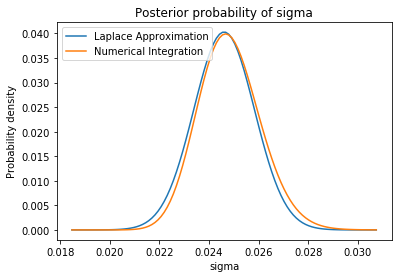

In [93]:
def plot_sigma_posterior_m1(raw_data):
    return plot_posterior_m1(raw_data, 1)


plot_sigma_posterior_m1(raw_training_data)

Here the Laplace Approximation looks less effective, but still pretty good.

### Bayesian analysis of Model 2

Our definition of Model 2 is very similar to Model1, with 2 differences:

1. We add a parameter $v$, such that $\Theta := (u, v, \sigma)$. Similarly to $u$, because $v := \sin(\epsilon)$, our prior distribution for $v$ is uniform on $[0, 1]$.
2. Our basis function $f_\Theta$ is more complex: 

$$f_{\Theta}(\phi_n, \psi_n) := \frac{v}{\cos(\phi_n)\sqrt{1 - u^2 \cos(\psi_n)^2}} + u \tan(\phi_n) \cos(\psi_n)$$

We'll now do the analysis by following the same steps as Model 1.

We represent our log-probabilities using SymPy:

In [96]:
v_bounds = (0, 1)

lp2_theta = np.log(1 / (u_bounds[1] - u_bounds[0])) + np.log(1 / (v_bounds[1] - v_bounds[0])) + sy.ln(1 / sigma) - np.log(np.log(sigma_bounds[1]) - np.log(sigma_bounds[0]))
lp2_theta

log(1/sigma) - 2.22032680636785

In [97]:
lp2_n = - sy.ln(sigma) - 0.5 * np.log(2 * np.pi) - (((t_n - p_n) / sigma)**2) / 2
lp2_n

-log(sigma) - 0.918938533204673 - (t_n - u*cos(psi_n)*tan(phi_n) - v/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n)))**2/(2*sigma**2)

We now find the MAP parameters:

In [98]:
def find_model2_map(raw_data):
    feat_mat = model2_feature_matrix(raw_data)
    
    t = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    theta0 = (0.0, 0.0, 0.1)
    theta_bounds = (u_bounds, v_bounds, sigma_bounds)
    
    return scp_bayes.find_map(lp2_theta, lp2_n, [t_n, phi_n, psi_n], [u, v, sigma], [t, phi, psi], theta0, theta_bounds)

m2_map = find_model2_map(raw_training_data)
m2_map

     fun: -548.3542544680583
    hess: array([[ 2.39637976e+05,  3.89568993e+04, -3.23052518e-09],
       [ 3.89568993e+04,  1.37810754e+06,  8.44011083e-10],
       [-3.23052518e-09,  8.44011083e-10,  1.62910205e+06]])
     jac: array([ 2.58069122e-11, -6.59383659e-12, -4.32166303e-10])
 message: 'Optimization terminated successfully.'
    nfev: 16
    nhev: 16
     nit: 15
    njev: 11
  status: 0
 success: True
       x: array([0.42866719, 0.0145868 , 0.01570865])

We now use the Laplace Approximation to get confidence intervals for $\alpha$ and $\epsilon$:

In [99]:
m2_alpha_99 = [np.arcsin(u) * 180 / np.pi for u in scp_bayes.laplace_99_confidence_interval(m2_map, 0)]
m2_alpha_99

[24.994086039920838, 25.773183418838254]

In [100]:
m2_eps_99 = [np.arcsin(v) * 180 / np.pi for v in scp_bayes.laplace_99_confidence_interval(m2_map, 1)]
m2_eps_99

[0.6890205557151041, 0.9825686095629951]

Let's now plot the posterior distributions for our parameters:

In [102]:
def plot_posterior_m2(raw_data, var_idx):
    feat_mat = model2_feature_matrix(raw_data)
    
    t = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    theta0 = (0.0, 0.0, 0.1)
    theta_bounds = (u_bounds, v_bounds, sigma_bounds)
    
    return plot_posterior(lp2_theta, lp2_n, [t_n, phi_n, psi_n], [u, v, sigma], 
              [t, phi, psi], theta0, theta_bounds,
              var_idx)

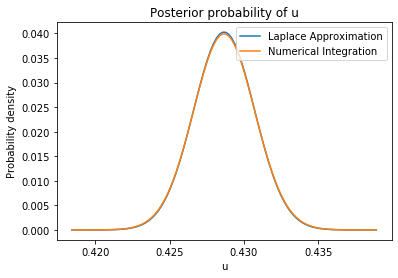

In [103]:
def plot_u_posterior_m2(raw_data):
    return plot_posterior_m2(raw_data, 0)
    
plot_u_posterior_m2(raw_training_data)

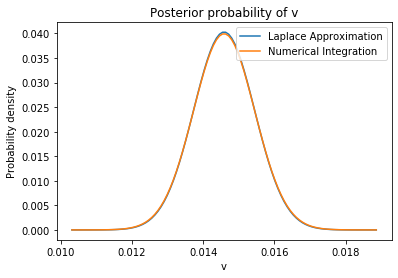

In [104]:
def plot_v_posterior_m2(raw_data):
    return plot_posterior_m2(raw_data, 1)

plot_v_posterior_m2(raw_training_data)

On my machine, these took much longer to execute, as it now involves integration in 3D. We start understanding why data scientists use specialized integration tools! (or approximations).